# Analysis of Visibility data

At this point, we should have received the data from the correlator and we would have recorded it in the following file

In [1]:

# test_case can be 1, 8, or 48
test_case = 1

rx_pcap = f"../../test-data/SPO-2289/correlator_output_05_{test_case}ch_new.pcap"


model = f"../../test-data/SPO-2289/models/vis_model_{test_case}ch.pickle"

Then we need to get necessary libraries ti analyse data

In [2]:
import os
import sys

os.environ["https_proxy"] = "http://delphoenix.atnf.csiro.au:8888"
!{sys.executable} -m pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple ska_low_cbf_model
!{sys.executable} -m pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple "ska-sdp-realtime-receive-modules>=3.8.1"
!{sys.executable} -m pip install scapy ipympl 
!{sys.executable} -m pip install dpkt
!{sys.executable} -m pip install spead2
!{sys.executable} --version

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Using cached https://artefact.skao.int/repository/pypi-internal/packages/ska-low-cbf-model/0.1.2/ska_low_cbf_model-0.1.2-py3-none-any.whl (26 kB)
  Using cached dpkt-1.9.8-py3-none-any.whl (194 kB)
  Using cached scapy-2.5.0-py2.py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Using cached https://artefact.skao.int/repository/pypi-internal/packages/ska-sdp-realtime-receive-modules/3.10.0/ska_sdp_realtime_receive_modules-3.10.0-py3-none-any.whl (41 kB)
  Using cached python_casacore-3.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.3 MB)
  Using cached overrides-7.3.1-py3-none-any.whl (17 kB)
  Using cached pyarrow-9.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.3 MB)
  Using cached https://artefact.skao.int/repository/pypi-internal/packages/ska-sdp-config/0.4.5/ska_sdp_co

Finally, let's load the visibilities generated from the model. 

In [20]:
import pickle
import dill

with open(model, 'rb') as handle:
    vis_model = dill.load(handle)
    
vis_model[1][0]['VIS']

array([[ 2084428.+0.00000e+00j, -1932094.-7.79848e+05j,
        -1932094.+7.79848e+05j,  2085652.+0.00000e+00j],
       [ 2083380.-2.59000e+02j, -1932604.-7.79736e+05j,
        -1932688.+7.79123e+05j,  2084386.+8.58000e+02j],
       [ 2085272.+0.00000e+00j, -1933106.-7.79005e+05j,
        -1933106.+7.79005e+05j,  2086113.+0.00000e+00j],
       [ 2083867.+1.36100e+03j, -1932370.-7.81463e+05j,
        -1932531.+7.77483e+05j,  2083682.+2.32700e+03j],
       [ 2084306.+1.65500e+03j, -1932971.-7.80721e+05j,
        -1933030.+7.77369e+05j,  2083908.+1.47300e+03j],
       [ 2086227.+0.00000e+00j, -1932846.-7.79090e+05j,
        -1932846.+7.79090e+05j,  2084696.+0.00000e+00j],
       [ 2086516.-1.90000e+01j, -1935420.-7.81146e+05j,
        -1936300.+7.77687e+05j,  2087274.+3.57500e+03j],
       [ 2086935.+2.46000e+02j, -1935911.-7.80434e+05j,
        -1936776.+7.77570e+05j,  2087480.+2.70900e+03j],
       [ 2087398.-1.37000e+03j, -1935844.-7.78813e+05j,
        -1936620.+7.79291e+05j,  2086779

## Fixing Spead 2 library

Spead 2 library needs fixing so that it can ingest pcap files properly. This is done by explicitly put the UDP protocol number 17 instead of using its full name in the BSD filter.

In [4]:
# Modify the SPEAD2 compiled library binary file so that it can work 
# in our jupyterhub container
spead2_so = "/opt/conda/lib/python3.10/site-packages/spead2/_spead2.cpython-310-x86_64-linux-gnu.so"
!sed -i.bak 's/\\udp/  17/' {spead2_so}
grep_check = !grep -w '\\udp' {spead2_so}
if not grep_check:
    # grep gives no output if no match
    print("Hack the planet!")
else:
    print("Hack failed :(")
    print(grep_check)

Hack the planet!


## Plot for visibility

This function is similar to the one in the visibility model notebook, we just need reproduce it in this notebook

In [5]:
def plot_visibilities(data, channel_name = 'unknown', n_baselines = None, prefix = ""):
    """
    data[baseline, time sample] - assumed to be one channel!
    (time is quantized in steps of 849ms)
    """
    if not n_baselines:
        n_baselines = data.shape[0]
    print(f"Plotting visibilities for {n_baselines} baselines")
    plt.figure(2)
    plt.clf()
    plt.subplot(2, 1, 1)
    clist = "rgbcmykrgbcmykrgbcmykrgbcmyk"
    for baseline in range(n_baselines):
        plt.plot(np.abs(data[baseline, :]), clist[baseline] + ".-")
    plt.ylim(0, 1.5 * np.max(np.abs(data[:, :])))
    plt.grid()
    plt.title(f"{prefix} Absolute value, {n_baselines} baselines, channel {channel_name}")
    plt.xlabel("time sample (0.849 seconds/sample)")

    plt.subplot(2, 1, 2)
    for baseline in range(n_baselines):
        plt.plot(np.angle(data[baseline, :]), clist[baseline] + ".-")
    plt.title(f"{prefix} Phase, {n_baselines} baselines, channel {channel_name}")
    plt.grid()
    plt.xlabel("time sample (0.849 seconds/sample)")
    plt.ylabel("phase (radians)")
    plt.show()

## Analysis of Alveo Correlator

From now we can simply ingest the SPEAD stream on the form of a pcap file inside the spead library and we should be able to extract baselines visibility in a structure called vis[c][t] of the form [('VIS','<c8', (4,)), ('TCI','|i1'), ('FD', '|u1')] (21,) where c is a visibility channel (between 0 and 143 in the simple example) and t is correlation time produce by the alveo 


Received 12672 heaps
The first heap with data (1152 / 0x402384000a5) had (assuming all heaps the same...):
	21 baselines
	SPEAD item names: Corre tOffs
Saving angle to Frequency plot for baseline number 3 aka station 1 vs station 3


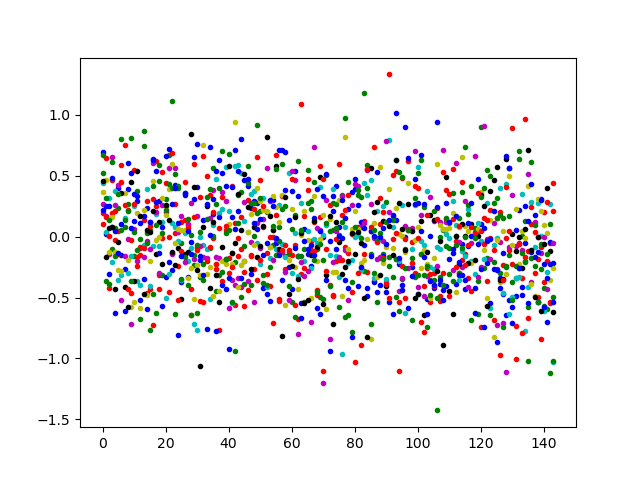

In [25]:
%matplotlib widget
## spead library example from Guillaume, modified...
from collections import defaultdict
import spead2, spead2.recv, logging
import numpy as np
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

test_case = 1

# Note evil hack required for Jupyter pod to use spead2 module...
# https://jira.skatelescope.org/browse/PERENTIE-1837?focusedCommentId=200282&page=com.atlassian.jira.plugin.system.issuetabpanels:comment-tabpanel#comment-200282

channel = 1# our channel of interest
verbose = False

# all visibilities - first keyed by channel, then time offset
# e.g. vis[23][849] => channel 23, time offset 849
vis = defaultdict(lambda: defaultdict(lambda: list()))
# SPEAD item keys
spead_items_seen = set()
n_baselines = -999
first_heap_with_data = None

# Initialise spead2 library
thread_pool = spead2.ThreadPool()
stream = spead2.recv.Stream(thread_pool)
del thread_pool


#vis_dst_port = 3457 + channel # each of the 144 channels goes to a different destination port
#stream.add_udp_pcap_file_reader(rx_pcap, filter=f"dst port {vis_dst_port}")
#
# Listen on all ports so we don't miss anything
stream.add_udp_pcap_file_reader(rx_pcap, filter=f"")
time_sequence = []
# Item group to retain
ig = spead2.ItemGroup()
for heap_number, heap in enumerate(stream):
    items = ig.update(heap)
    if verbose:
        # General information about heap
        flavour = heap.flavour
        print(f"Heap {heap.cnt:#X} ("
              f"SPEAD-{flavour.item_pointer_bits}-{flavour.heap_address_bits} "
              f"v{heap.flavour.version})", end="")
        if heap.is_start_of_stream():
            print("\t(start of stream)")
        if heap.is_end_of_stream():
            print("\t(end of stream)")
        print()
    # don't process start/end packets any further
    if heap.is_start_of_stream():
        for key, item in items.items():
            if key == "Basel":
                n_baselines= item.value
        continue
        
    elif heap.is_end_of_stream():
        continue
    
    if first_heap_with_data is None:
        first_heap_with_data = (heap_number, heap.cnt)  # our enumeration count, heap ID
    
    # Extract correlation data
    for key, item in items.items():
        if heap_number == first_heap_with_data[0] and key == "Basel":
            n_baselines= item.value
        if heap_number == first_heap_with_data[0]:
            spead_items_seen.add(key)
        
        # this loop is silly, but this doesn't work:
        #x = items["Corre"]  # why doesn't this work?!
        if key == "Corre":
            #print(f"Found a correlation for heap {heap.cnt:#x}")
            visibility_baseline_data = item.value
            #print(f"CORRELATION VALUE: {item.value}")
        elif key == "tOffs":
            t = item.value
    heap_number_byte = heap.cnt.to_bytes(6, byteorder="big")
    byte_array_heap_number_byte = bytearray(heap_number_byte)
    
    chan=int.from_bytes(byte_array_heap_number_byte[2:4], "big")

    

    try:
        vis[chan][t] = visibility_baseline_data
        #print(f"channel {chan} time {t} {visibility_baseline_data}")
        if t not in time_sequence:
            time_sequence.append(t)
        # dirty way to stop old data carrying over (FIXME)
        del chan
        del t
        del visibility_baseline_data
    except NameError:
        print("Something went wrong in heap number {heap_number}")
        


stream.stop()
print()
print(f"Received {heap_number+1} heaps")
print(f"The first heap with data ({first_heap_with_data[0]} / {first_heap_with_data[1]:#x}) had (assuming all heaps the same...):")
print(f"\t{n_baselines} baselines")
print("\tSPEAD item names:", " ".join(spead_items_seen))

print("Saving angle to Frequency plot for baseline number 3 aka station 1 vs station 3")
correlator_frames = 10
nb_vis_channels = 144*test_case
nb_stations = 6
nb_baselines = 21
fig = plt.figure(3)
clist = "rgbcmykrgb"
plt.clf()
for frame in range(correlator_frames):
    for channel in range(nb_vis_channels):
        plt.plot(channel, (180/3.14159265)*np.angle(vis[100*144+channel][time_sequence[frame]]['VIS'][3][0]), clist[frame] + ".-", label=f"frame {frame}")

fig.savefig('angle_freq.png', bbox_inches='tight')

In [28]:
print("Calculating the maximum difference in amplitude between the firmare and the model")

visu_type = visu_type = np.dtype([('VIS','<c8', (4,)), ('TCI','|i1'), ('FD', '|u1')])
empty_content =  np.zeros((21,), dtype=visu_type) 
channels = range(0,nb_vis_channels)
print(channels)
maximum_difference = 0
for correlator_frame in range(10):
    # print(packet_contents['VIS'])
    for channel in channels:
        #print(f"channel {channel}, frame {correlator_frame} ")
        #print(f"data {vis_model[channel][correlator_frame]['VIS']}")
        if (vis[100*144+channel][time_sequence[correlator_frame]+correlator_frame*849000000]['VIS']-vis_model[channel][correlator_frame]['VIS']).all() != empty_content['VIS'].all():
            difference = (vis[100*144+channel][time_sequence[correlator_frame]+correlator_frame*849000000]['VIS']-vis_model[channel][(correlator_frame)]['VIS'])

            difference_proportion = np.abs(difference)/np.abs(vis_model[channel][(correlator_frame)]['VIS'])
            #print(difference_proportion)
            maximum_difference = max(maximum_difference, difference_proportion.max())
        
print(maximum_difference)

Calculating the maximum difference in amplitude between the firmare and the model
range(0, 144)
channel 0, frame 0 
data [[ 2048959.+0.00000e+00j -1898990.-7.64436e+05j -1898990.+7.64436e+05j
   2048208.+0.00000e+00j]
 [ 2046110.+1.31800e+03j -1897240.-7.65132e+05j -1898890.+7.62882e+05j
   2046043.+1.40400e+03j]
 [ 2046237.+0.00000e+00j -1897179.-7.63579e+05j -1897179.+7.63579e+05j
   2046844.+0.00000e+00j]
 [ 2048399.+2.25800e+03j -1899022.-7.66845e+05j -1900728.+7.62574e+05j
   2047638.+2.33100e+03j]
 [ 2047110.+9.37000e+02j -1898983.-7.65322e+05j -1898975.+7.63321e+05j
   2046964.+9.45000e+02j]
 [ 2050934.+0.00000e+00j -1900792.-7.65060e+05j -1900792.+7.65060e+05j
   2050095.+0.00000e+00j]
 [ 2046370.+1.80300e+03j -1897321.-7.65655e+05j -1899611.+7.62257e+05j
   2046481.+2.21600e+03j]
 [ 2045005.+4.76000e+02j -1897203.-7.64124e+05j -1897832.+7.63011e+05j
   2045829.+8.28000e+02j]
 [ 2047372.-4.80000e+02j -1899061.-7.63813e+05j -1899690.+7.64772e+05j
   2047376.-1.22000e+02j]
 [ 204

TypeError: list indices must be integers or slices, not str